In [1]:
import gc; gc.collect()
%reset -f
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

In [2]:
from mglvq import MGLVQ as MGLVQ
from M3GLVQ import M3GLVQ as M3GLVQ 

In [3]:
from functions import (
    align_square_matrix_to_df_order,
    align_matrices_to_df,
    visualize_from_distance_and_model,
    stratified_kfold_grid_search,
    stratified_kfold_bayes_search,
    )

2025-11-24 08:22:33.208084: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-24 08:22:33.222477: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-11-24 08:22:33.238141: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-11-24 08:22:33.242843: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-11-24 08:22:33.254652: I tensorflow/core/platform/cpu_feature_guar

# read data

## y

In [16]:
y = pd.read_pickle('data/y.pkl')
y

,CustomerCode,y
0,C00003,1
1,C00004,1
2,C00005,1
3,C00006,0
4,C00007,1
...,...,...
2037,C02408,1
2038,C02409,0
2039,C02410,0
2040,C02411,0


## matrizes

In [5]:
D_expert_weighted = pd.read_pickle('data/D_MGLVQ.pkl')
D_modell_weighted = pd.read_pickle('data/D_M3GLVQ.pkl')
D_naics = pd.read_pickle('data/D_naics.pkl')
D_hs = pd.read_pickle('data/D_hs.pkl')
D_am =pd.read_pickle('data/D_am.pkl')
D_geo = pd.read_pickle('data/D_geo.pkl')

In [6]:
mats = {
    "D_expert_weighted": D_expert_weighted,
    "D_modell_weighted": D_modell_weighted,
    "D_naics":    D_naics,
    "D_hs":       D_hs,
    "D_am":       D_am,
    "D_geo":      D_geo,
    
}

for name, D in mats.items():
    print(f"{name}: shape={D.shape}")

D_expert_weighted: shape=(2042, 2042)
D_modell_weighted: shape=(2042, 2042)
D_naics: shape=(2042, 2042)
D_hs: shape=(2042, 2042)
D_am: shape=(2042, 2042)
D_geo: shape=(2041, 2041)


# preparation

## MGLVQ

In [17]:
D_MGLVQ = align_square_matrix_to_df_order(D_expert_weighted, y, id_col="CustomerCode", return_numpy=False)
y_MGLVQ = np.asarray(y['y'].to_numpy().astype(int))
display(len(y_MGLVQ))
display(D_MGLVQ.shape)

2042

(2042, 2042)

## M$^3$GLVQ

In [8]:
#test
mats = {
    "D_modell_weighted":   D_modell_weighted,
    "D_naics":    D_naics,
    "D_hs":       D_hs,
    "D_am":       D_am,
    "D_geo":      D_geo,
}

aligned_np, y_M3GLVQ, ordered_ids = align_matrices_to_df(
    mats, y, id_col="CustomerCode",
    matrices_as_numpy=True, set_globals=True
)

D_modell_weighted   = aligned_np["D_modell_weighted"]
D_naics             = aligned_np["D_naics"]
D_hs                = aligned_np["D_hs"]
D_am                = aligned_np["D_am"]
D_geo               = aligned_np["D_geo"]

[1] Common ID set across all matrices: 2041 IDs
[2] df restricted to common IDs: 2041 rows | unique IDs in df order: 2041
[3] D_modell_weighted_p_aligned -> (2041, 2041) (ndarray)
[3] D_naics_p_aligned -> (2041, 2041) (ndarray)
[3] D_hs_p_aligned -> (2041, 2041) (ndarray)
[3] D_am_p_aligned -> (2041, 2041) (ndarray)
[3] D_geo_p_aligned -> (2041, 2041) (ndarray)
[4] df_cut -> Series 'y' with length 2041


In [9]:
def robust_scale(D):
    
    D = D.astype(np.float32)  # save RAM
    med = np.median(D[D > 0]) if np.any(D > 0) else 1.0
    return D / (med + 1e-12)


# Example: scale four distance matrices
D_naics_scaled = robust_scale(D_naics)
D_hs_scaled    = robust_scale(D_hs)
D_am_scaled    = robust_scale(D_am)
D_geo_scaled   = robust_scale(D_geo)

# 3) Build DL (four views)
DL = [D_naics_scaled, D_hs_scaled, D_am_scaled, D_geo_scaled]


# parameter optimization

## MGLVQ

### Gridsearch 1

In [ ]:
# param_grid_mglvq = {
#     "K": [3, 4, 5, 6, 7, 8, 9],
#     "T": [100],
#     "track_path": [True],
# }
# y 
# res_mglvq = stratified_kfold_grid_search(
#     D_MGLVQ,
#     y_MGLVQ,
#     MGLVQ,
#     param_grid_mglvq,
#     scoring="balanced_accuracy",
#     n_splits=5,
#     save_path="parameter_optimization/grid_search/MGLVQ.pkl",
#     table_path="parameter_optimization/grid_search/MGLVQ_all_folds.pkl",
# )


In [20]:
results = pd.read_pickle('parameter_optimization/grid_search/MGLVQ.pkl')

In [21]:
def mean_balanced_accuracy(entry):
    folds = entry["cv_result"]["folds"]
    return sum(f["balanced_accuracy"] for f in folds) / len(folds)

best_entry = max(results["all_results"], key=mean_balanced_accuracy)
best_params = best_entry["params"]
best_mean_bal_acc = mean_balanced_accuracy(best_entry)

print("Best parameters based on mean balanced accuracy across folds:")
print(best_params)
print("Mean balanced accuracy:", best_mean_bal_acc)

Best parameters based on mean balanced accuracy across folds:
{'K': 8, 'T': 100, 'track_path': True}
Mean balanced accuracy: 0.6337815770351516


### Visualization

In [18]:
D_MGLVQ = align_square_matrix_to_df_order(D_expert_weighted, y, id_col="CustomerCode", return_numpy=True)

model = MGLVQ(K= 8, T=100, track_path=True)
model.fit(D_MGLVQ, y_MGLVQ)
display(model.score(D_MGLVQ, y_MGLVQ))

0.7590597453476984

/home/pmlb/miniconda3/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
/home/pmlb/miniconda3/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/pmlb/miniconda3/lib/python3.10/site-packages/umap/umap_.py:1865: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
/home/pmlb/miniconda3/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


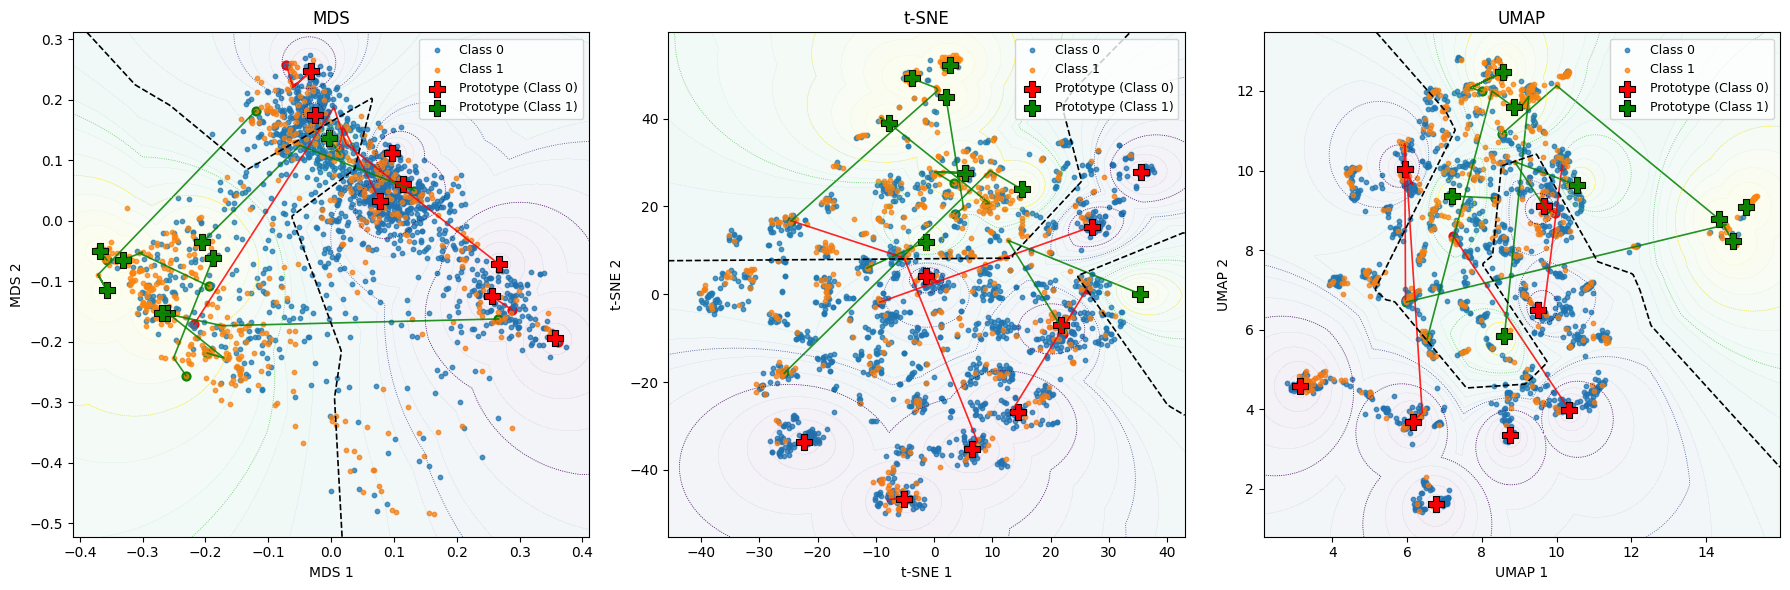

In [19]:
fig, axes, emb = visualize_from_distance_and_model(model, D_MGLVQ, y_MGLVQ, show_trajectories=True)

## M$^3$GLVQ

### Bayes Search

In [ ]:
# param_grid_v2 = {
#     "label_to_K_values": {
#         0: [3, 4, 5, 6, 7, 8, 9, 10],
#         1: [3, 4, 5, 6, 7, 8, 9, 10],
#     },
#     "T": [200],  # fix
#     "eta": [0.025, 0.05, 0.1, 0.25],
#     "v_init": [
#         [0.25, 0.25, 0.25, 0.25],
#         [0.3,  0.2,  0.4,  0.1],
#         [0.55, 0.15, 0.15, 0.15],
#         [0.15, 0.55, 0.15, 0.15],
#         [0.15, 0.15, 0.55, 0.15],
       
#     ],
#     "track_path": [True],
#     "track_vweights": [True],
#     "track_metrics": [True],
# }

# res_v2_bayes = stratified_kfold_bayes_search(
#     D=DL,
#     y=y,
#     model_cls=M3GLVQ,
#     param_grid=param_grid_v2,
#     scoring="balanced_accuracy",
#     n_splits=5,
#     n_trials=200,
#     verbose=True,
#     save_path="parameter_optimization/bayes_search/M3GLVQ.pkl",
#     study_name="m3glvq_bayes_balanced_accuracy",
# )



In [ ]:
# rows = []
# all_results = df_bayes["all_results"]


# def folds_to_df(all_results):
#     """
#     Convert all trial/fold results from a Bayesian search into a flat DataFrame.

#     Parameters
#     ----------
#     all_results : list of dict
#         List of trial result dictionaries (as stored in df_bayes["all_results"]).

#     Returns
#     -------
#     pd.DataFrame
#         One row per (trial, fold) with:
#         - trial/fold metrics,
#         - hyperparameters (flattened),
#         - final v-weights split into separate columns.
#     """
#     rows = []

#     for trial in all_results:
#         trial_num = trial["trial_number"]
#         score = trial["score"]
#         model_cls = trial["cv_result"]["model_cls"]

#         # Parameters of this trial
#         params = trial.get("params", {})
#         K = params.get("K", {})

#         for fold in trial["cv_result"]["folds"]:
#             row = {
#                 "trial_number": trial_num,
#                 "score": score,
#                 "model_cls": model_cls,
#                 "fold": fold["fold"],
#             }

#             # --- Fold metrics & counts ---
#             for k, v in fold.items():
#                 if k not in ("fold", "final_vweights"):
#                     row[k] = v

#             # final_vweights kept as an array
#             row["final_vweights"] = np.asarray(fold["final_vweights"])

#             # --- Flatten parameters ---

#             # 1) K: dict -> individual columns K_0, K_1, ...
#             if isinstance(K, dict):
#                 for k_key, k_val in K.items():
#                     row[f"K_{k_key}"] = k_val
#             else:
#                 # fallback if K is something else
#                 row["K"] = K

#             # 2) Remaining parameters directly copied
#             for p_key, p_val in params.items():
#                 if p_key == "K":
#                     continue  # already handled above
#                 row[p_key] = p_val

#             rows.append(row)

#     df_folds = pd.DataFrame(rows)

#     # Turn v-weights into a 2D array
#     weights = df_folds["final_vweights"].apply(lambda x: np.asarray(x))
#     W = np.vstack(weights.values)   # Shape: (n_rows, 4) or (n_rows, n_vweights)

#     # Create separate columns for each v-weight (adjust number if needed)
#     df_folds[["vweight_1", "vweight_2", "vweight_3", "vweight_4"]] = W

#     return df_folds


In [ ]:
# all_results = df_bayes["all_results"]   # oder passender Index
# df_folds = folds_to_df(all_results)

In [22]:
df_folds= pd.read_pickle('parameter_optimization/bayes_search/M3GLVQ.pkl')

In [23]:
threshold = df_folds["balanced_accuracy"].quantile(0.9)
df_high = df_folds[df_folds["balanced_accuracy"] >= threshold]

v_cols = ["vweight_1", "vweight_2", "vweight_3", "vweight_4"]
df_high[['vweight_1','vweight_2','vweight_3','vweight_4','balanced_accuracy']]

,vweight_1,vweight_2,vweight_3,vweight_4,balanced_accuracy
3,0.028840,0.020338,0.012258,0.938564,0.719738
63,0.000000,0.000000,0.847134,0.152866,0.719250
73,0.029866,0.285749,0.576652,0.107732,0.706589
78,0.000000,0.000000,0.000000,1.000000,0.704912
113,0.036829,0.121949,0.750092,0.091131,0.716595
...,...,...,...,...,...
963,0.190446,0.179614,0.455175,0.174766,0.715680
978,0.000000,0.000000,0.000000,1.000000,0.721629
983,0.236305,0.305052,0.297059,0.161584,0.727151
988,0.207761,0.198466,0.407812,0.185961,0.706101


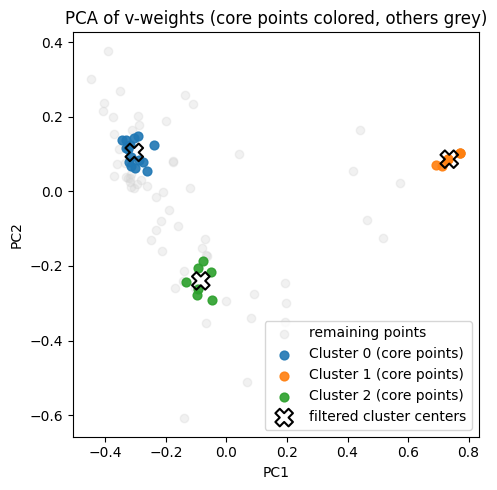


Cluster 0  (members: 52)
Mean balanced accuracy: 0.7143356643356642
Center (v1–v4): [0.09818097 0.14573831 0.6202907  0.13579002]

Cluster 2  (members: 26)
Mean balanced accuracy: 0.7154875718634108
Center (v1–v4): [0.24845583 0.28145311 0.27066072 0.19943034]

Cluster 1  (members: 23)
Mean balanced accuracy: 0.7127291296389634
Center (v1–v4): [0.01313992 0.01172297 0.0103764  0.96476071]


In [25]:
# ---- Setup ----
# v_cols e.g.: ["vweight_0", "vweight_1", "vweight_2", "vweight_3"]
X = df_high[v_cols].values
k = 3

# ---- PCA: 4D -> 2D ----
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

df_high = df_high.copy()
df_high["PC1"] = X_pca[:, 0]
df_high["PC2"] = X_pca[:, 1]

# ---- KMeans clustering on the v-weights ----
kmeans = KMeans(n_clusters=k, random_state=0).fit(X)
labels = kmeans.labels_
cluster_centers = kmeans.cluster_centers_

df_high["cluster"] = labels

# ---- Select core points per cluster (e.g. 30% closest to the center) ----
top_frac = 0.30  # fraction of points per cluster used to compute filtered centers

core_mask = np.zeros(len(df_high), dtype=bool)

for c in range(k):
    idx_c = np.where(labels == c)[0]
    X_c = X[idx_c]
    center = cluster_centers[c]

    dists = np.linalg.norm(X_c - center, axis=1)
    n_top = max(1, int(len(idx_c) * top_frac))
    idx_sorted = np.argsort(dists)
    core_idx_cluster = idx_c[idx_sorted[:n_top]]

    core_mask[core_idx_cluster] = True

# ---- Recompute new centers only from core points ----
filtered_centers = np.zeros_like(cluster_centers)

for c in range(k):
    mask_core_c = (labels == c) & core_mask
    X_c_core = X[mask_core_c]
    if len(X_c_core) > 0:
        filtered_centers[c] = X_c_core.mean(axis=0)
    else:
        # Fallback: if cluster is extremely small, keep the original KMeans center
        filtered_centers[c] = cluster_centers[c]

# ---- PCA scatter plot: core points colored, others grey ----
centers_pca = pca.transform(filtered_centers)

plt.figure(figsize=(5, 5))

# 1) all non-core points in grey
plt.scatter(
    df_high.loc[~core_mask, "PC1"],
    df_high.loc[~core_mask, "PC2"],
    color="lightgray",
    alpha=0.3,
    label="remaining points"
)

# 2) core points per cluster in color
colors = ["C0", "C1", "C2", "C3", "C4", "C5"]
for c in range(k):
    mask_c_core = (df_high["cluster"] == c) & core_mask
    plt.scatter(
        df_high.loc[mask_c_core, "PC1"],
        df_high.loc[mask_c_core, "PC2"],
        s=40,
        color=colors[c % len(colors)],
        alpha=0.9,
        label=f"Cluster {c} (core points)"
    )

# 3) filtered centers in PCA space
plt.scatter(
    centers_pca[:, 0],
    centers_pca[:, 1],
    marker="X",
    s=160,
    edgecolor="black",
    facecolor="none",
    linewidth=1.5,
    label="filtered cluster centers"
)

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA of v-weights (core points colored, others grey)")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

# ---- Collect cluster information (with new centers) ----
cluster_info = []

for c in range(k):
    df_cluster = df_high[df_high["cluster"] == c]
    size = len(df_cluster)
    mean_acc = df_cluster["balanced_accuracy"].mean()
    center = filtered_centers[c]  # new center computed from core points only

    cluster_info.append({
        "cluster": c,
        "size": size,
        "mean_balanced_accuracy": mean_acc,
        "center": center
    })

# ---- Sort by cluster size (descending) ----
cluster_info_sorted = sorted(cluster_info, key=lambda x: x["size"], reverse=True)

# ---- Print summary ----
for info in cluster_info_sorted:
    print(f"\nCluster {info['cluster']}  (members: {info['size']})")
    print("Mean balanced accuracy:", info["mean_balanced_accuracy"])
    print("Center (v1–v4):", info["center"])


### Gridsearch 1

In [ ]:
# param_grid_v2 = {
#     # automatically generate all K combinations from these lists:
#     "label_to_K_values": {
#         0: [3, 4, 5, 6, 7, 8, 9, 10],   # candidate K values for label 0
#         1: [3, 4, 5, 6, 7, 8, 9, 10],   # candidate K values for label 1
#     },
#     "T": [100],
#     "eta": [0.0],
#     "v_init": [
#         [0.1,  0.145, 0.62,  0.135],
#         # [0.3, 0.2, 0.4, 0.1],
#         # [0.2, 0.2, 0.2, 0.4],
#     ],
#     "track_path": [True],
#     "track_vweights": [True],
#     "track_metrics": [True],
# }

# res_v2 = stratified_kfold_grid_search(
#     D=DL,
#     y=y,
#     model_cls=M3GLVQ,
#     param_grid=param_grid_v2,
#     scoring="balanced_accuracy",              # used as key in "averages"
#     n_splits=5,
#     verbose=True,                             # show progress bar + best-of-run
#     save_path="parameter_optimization/grid_search/M3GLVQ.pkl",
# )


In [26]:
M3GLVQ_grid_search = pd.read_pickle("parameter_optimization/grid_search/M3GLVQ.pkl")

In [27]:
# -----------------------------------------
# 1) Split K-column into separate columns
# -----------------------------------------
# df = test_df.copy()
df = M3GLVQ_grid_search.copy()
K_expanded = df["K"].apply(pd.Series).add_prefix("K_")  # → K_0, K_1, ...
df = pd.concat([df.drop(columns=["K"]), K_expanded], axis=1)

# automatically detect all K-columns
k_cols = [c for c in df.columns if c.startswith("K_")]

# -----------------------------------------
# 2) Define metric columns
#    (explicit here for clarity)
# -----------------------------------------
metric_cols = [
    "balanced_accuracy",
    "recall",
]

# Mean value per K-combination across all folds
agg_dict = {m: "mean" for m in metric_cols}

grouped = (
    df
    .groupby(k_cols)
    .agg(agg_dict)
    .reset_index()
)

# -----------------------------------------
# 3) Ranks per metric (higher = better → ascending=False)
# 4) Rank sum
# -----------------------------------------
rank_cols = []

for m in metric_cols:
    rank_col = f"rank_{m}"
    grouped[rank_col] = grouped[m].rank(method="min", ascending=False)
    rank_cols.append(rank_col)

grouped["rank_sum"] = grouped[rank_cols].sum(axis=1)

# -----------------------------------------
# 5) Top 5 combinations with smallest rank sum
# -----------------------------------------
top5 = grouped.sort_values("rank_sum", ascending=True).head(5)

top5


,K_0,K_1,balanced_accuracy,recall,rank_balanced_accuracy,rank_recall,rank_sum
4,3,7,0.675242,0.602162,1.0,8.0,9.0
15,4,10,0.673414,0.591794,4.0,10.0,14.0
3,3,6,0.663965,0.629943,19.0,5.0,24.0
23,5,10,0.660845,0.676724,25.0,1.0,26.0
7,3,10,0.673672,0.555397,3.0,25.0,28.0


### Visualization

In [10]:
model = M3GLVQ(
    K={0: 3, 1: 7},
    T=100,
    eta=0,  # .025,
    v_init=[0.1, 0.145, 0.62, 0.135],
    track_path=True,
    track_vweights=True,
    track_metrics=True,
)

y_2 = np.asarray(y_M3GLVQ.to_numpy().astype(int))
model.fit(DL, y_2)

print("Learned view weights (sum = 1):", model._vWeights)  # length 4
print("Prototype indices:", model._w)                      # length = K * #classes
# print("Training accuracy:", model.score(DL, y))

# (Optional) show prototypes per class
for c in np.unique(y_2):
    proto_ids = model._w[model._y == c]
    print(f"Class {c}: {len(proto_ids)} prototypes -> indices {proto_ids}")

print("Training accuracy:", model.score(DL, y_2))


/home/pmlb/miniconda3/lib/python3.10/site-packages/proto_dist_ml/rng.py:152: RuntimeWarning: invalid value encountered in divide
  self._Alpha /= np.expand_dims(np.sum(self._Alpha, axis=1), 1)


Learned view weights (sum = 1): [0.1   0.145 0.62  0.135]
Prototype indices: [1860 1329 2021  575  356   88  798  868 1033  803]
Class 0: 3 prototypes -> indices [1860 1329 2021]
Class 1: 7 prototypes -> indices [ 575  356   88  798  868 1033  803]
Training accuracy: 0.7501224889759922


/home/pmlb/miniconda3/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
/home/pmlb/miniconda3/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/pmlb/miniconda3/lib/python3.10/site-packages/umap/umap_.py:1865: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
/home/pmlb/miniconda3/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


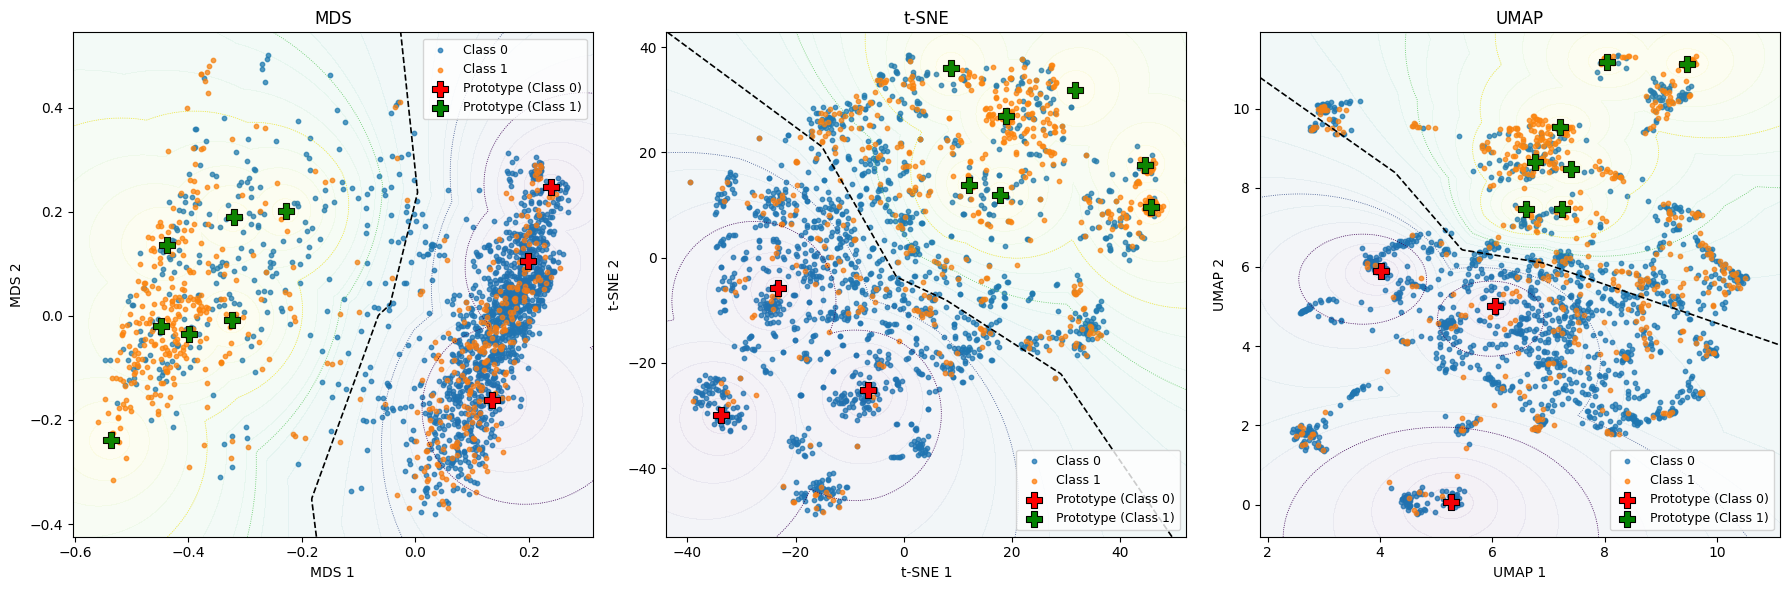

In [11]:
D = model.get_final_matrix()
fig, axes, emb = visualize_from_distance_and_model(model, D, y, show_trajectories=False)

# Evaluation

## Stratified 100 fold procedure

### MGLVQ

In [ ]:
# param_grid_mglvq = {
#     "K": [8],
#     "T": [100],
#     "track_path": [True],
# }

# res_mglvq = stratified_kfold_grid_search(
#     D_MGLVQ,
#     y_MGLVQ,
#     MGLVQ,
#     param_grid_mglvq,
#     scoring="balanced_accuracy",
#     n_splits=100,
#     save_path="parameter_optimization/grid_search/MGLVQ_100_folds.pkl",
#     table_path="parameter_optimization/grid_search/MGLVQ_100_folds.pkl",
# )


### M$^3$GLVQ

In [ ]:
# param_grid_v2 = {
#     "label_to_K_values": {
#         0: [3],
#         1: [7],
#     },
#     "T": [100],
#     "eta": [0],
#     "v_init": [
#         [0.1, 0.145, 0.62, 0.135],
       
#     ],
#     "track_path": [True],
#     "track_vweights": [True],
#     "track_metrics": [True],
# }

# res_v2 = stratified_kfold_grid_search(
#     D=DL,
#     y=y,
#     model_cls=M3GLVQ,
#     param_grid=param_grid_v2,
#     scoring="balanced_accuracy",
#     n_splits=100,
#     verbose=True,
#     save_path="parameter_optimization/grid_search/M3GLVQ_100_folds.pkl",
#     table_path="parameter_optimization/grid_search/M3GLVQ_100_folds.pkl",  
# )


### Comparision

In [28]:
df_M3GLVQ = pd.read_pickle("parameter_optimization/grid_search/M3GLVQ_100_folds.pkl")
df_MGLVQ  = pd.read_pickle("parameter_optimization/grid_search/MGLVQ_100_folds.pkl")
cols = ['balanced_accuracy', 'recall', 'precision', 'TP', 'FP', 'TN', 'FN']

def mean_pm_std(df):
    mean = df[cols].mean()
    std  = df[cols].std()
    return (mean.round(4).astype(str) + " ± " + std.round(4).astype(str))

overview = pd.DataFrame({
    "MGLVQ": mean_pm_std(df_MGLVQ),
    "M3GLVQ": mean_pm_std(df_M3GLVQ)
})

print(overview)


                               MGLVQ             M3GLVQ
balanced_accuracy     0.6395 ± 0.135     0.661 ± 0.1198
recall               0.5043 ± 0.2636     0.575 ± 0.2477
precision            0.4599 ± 0.2309    0.4926 ± 0.2082
TP                  13.5595 ± 7.0794    15.469 ± 6.6522
FP                 16.4548 ± 10.0471  18.4929 ± 13.3363
TN                 56.5952 ± 10.1696  54.5429 ± 13.3264
FN                  13.3905 ± 7.1989   11.4952 ± 6.7549
